Jupyter notebook for analyzing the jobs for a particular zipcode. 
Dice.com provides a convinient REST API to retrieve jobs in `json` format. The jobs retrieved from Dice API are cleaned and stored in MongoDB as json documents. MongoDB's aggregation framework is used to do the analysis. Python 3.6 along with Pymongo driver is used to interact with MongoDB. Finally, plots are displayed using Matplotlib and seaborn packages.

Code for DiceDAO is given below. The objective of this class is the initialize the connection to MongoDB and provide an interface to insert data into MongoDB, do ad-hoc analysis using simple `find` and complex `aggregration pipeline` queries. 

In [1]:
import requests

class DiceDAO:
    def __init__(self, db, jobType, location):
        self._db = db

        # Clean jobType
        # 1. replace spaces with '+'
        # 2. convert to lower case
        self._jobType = jobType.replace(" ", "+").lower()

        # location, use zipcode
        self._location = location

        # Derive the collection name as
        # collectionName = jobType + location
        # eg: datascientist07059
        self._collection = getattr(self._db, jobType.replace(" ", "").lower() + location)

        # Construct the URL
        self._url = "http://service.dice.com/api/rest/jobsearch/v1/simple.json?text={}&city={}".format(self._jobType,
                                                                                                       self._location)

    def retrieveJobs(self):
        print("Retrieving jobs from URL:")
        print(self._url)

        # Drop the collection to start fresh
        print("Dropping collection {}".format(getattr(self._collection, 'name')))
        self._collection.drop()

        # Retrieve jobs from the url and store them into mongodb
        # Handle pagination and store all of the docs in one collection

        r = requests.get(self._url)
        json_data = r.json()

        for item in json_data['resultItemList']:
            self._collection.insert_one(item)

        while json_data['count'] != json_data['lastDocument']:

            # get nextUrl for paginated results
            nextURL = json_data['nextUrl']
            r = requests.get("http://service.dice.com" + nextURL)

            json_data = r.json()
            for item in json_data['resultItemList']:
                self._collection.insert_one(item)


    def countJobs(self):

        print("Count the jobs for a jobTitle and location")
        return (self._collection.count())


    def filterJobsByCity(self, city):

        print("Filtering jobs by city")

        # Construct query to be sent to mongodb
        query = {"location": city}
        projection = {"_id":0, "detailUrl": 0}

        cursor = self._collection.find(query, projection)

        for item in cursor:
            print(item)

    def groupByLocation(self):

        print("Grouping by city and counting the number of jobs")

        query = [{"$group": {
            "_id": "$location",
            "totalJobs": {"$sum": 1}
        }}]

        cursor = self._collection.aggregate(query)

        for item in cursor:
            print(item)

    def groupJobsByCompany(self):

        print("Grouping jobs by company")

        query = [{"$group": {
            "_id": "$company",
            "totalJobs": {"$sum": 1}
            }
        },
            {"$sort":{
                "totalJobs":-1
            }
        }
        ]

        cursor = self._collection.aggregate(query)

        return(cursor)

        #for item in cursor:
            #print(item)


    def topCompanies(self):

        print("Printing top companies")

        query = [{"$group": {
            "_id": "$company",
            "totalJobs": {"$sum": 1}
            }
        },
            {"$sort":{
                "totalJobs":-1
            }
        },
            {"$project": {
                "_id":0,
                "Company":"$_id",
                "JobCount":"$totalJobs"
            }
        },
            {"$limit":20}
        ]

        return(self._collection.aggregate(query))

Code for analysis.py is given below. 

In [2]:
import pymongo
import pandas as pd


from diceDAO import DiceDAO

# Get a handle to connection object
connection = pymongo.MongoClient("mongodb://localhost")
db = connection.jobs

# Pass the connection object, job type, zipcode
diceJobs = DiceDAO(db, "Data Scientist", "07059")

# Retrieve the jobs from dice API and store in mongodb.
diceJobs.retrieveJobs()

# Get the top 20 companies hiring the desired skill
cursor = diceJobs.topCompanies()

# Use pandas to create a dataframe
df = pd.DataFrame(list(cursor))

# print the dataframe
print(df)

Retrieving jobs from URL:
http://service.dice.com/api/rest/jobsearch/v1/simple.json?text=data+scientist&city=07059
Dropping collection datascientist07059


Printing top companies
                           Company  JobCount
0                      CyberCoders       149
1           Robert Half Technology       109
2                      Kforce Inc.        66
3                              UBS        59
4                         Deloitte        58
5        Capital Markets Placement        48
6        Princeton Information Ltd        47
7                    Matlen Silver        44
8         U.S. Tech Solutions Inc.        42
9              Gambit Technologies        41
10                  Bloomberg L.P.        40
11                 Design Strategy        39
12  Software Guidance & Assistance        34
13                 The Judge Group        33
14                 JP Morgan Chase        28
15                    Hyatt Leader        23
16           Mitchell Martin, Inc.        22
17           Futures Group IT LLC.        21
18                  NTT DATA, Inc.        20
19                TEKsystems, Inc.        19


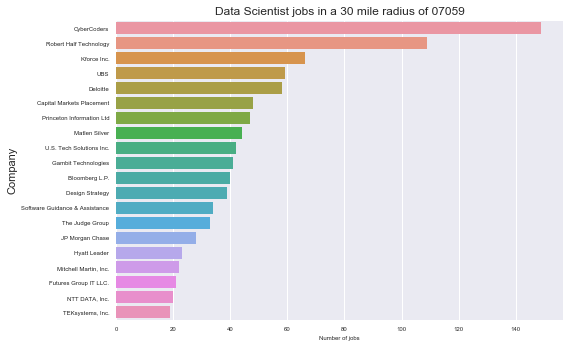

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def displayBarPlot(dataFrame):
    # plot a bar plot
    sns.barplot(x="JobCount", y="Company", data=dataFrame, orient="h")
    plt.xlabel("Number of jobs", fontsize=6)
    plt.title("{} jobs in a 30 mile radius of {}".format("Data Scientist", "07059"))
    plt.yticks(fontsize=6)
    plt.xticks(fontsize=6)
    plt.show()
    
displayBarPlot(df)